In [1]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-community-1')

diarization = pipeline('cocktail_party_sample.wav')

for turn, speaker in diarization.speaker_diarization:
    print(f"{speaker} speaks between t={turn.start:.4f}s and t={turn.end:.4f}s")

/home/tancrede/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-mqci4glv because there was an issue with the default path (/home/tancrede/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/tancrede/miniconda3/envs/voice_hack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tancrede/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/nati

SPEAKER_00 speaks between t=6.7303s and t=6.7472s
SPEAKER_01 speaks between t=6.7472s and t=7.0341s
SPEAKER_00 speaks between t=7.0341s and t=7.1860s
SPEAKER_00 speaks between t=7.5910s and t=7.6078s
SPEAKER_01 speaks between t=7.6078s and t=8.3166s
SPEAKER_00 speaks between t=8.3166s and t=9.9197s
SPEAKER_01 speaks between t=9.9197s and t=10.9828s
SPEAKER_00 speaks between t=10.4597s and t=14.7460s
SPEAKER_01 speaks between t=14.3072s and t=17.8847s
SPEAKER_00 speaks between t=18.0197s and t=21.5128s
SPEAKER_01 speaks between t=18.1547s and t=18.4416s
SPEAKER_01 speaks between t=21.7660s and t=28.4991s
SPEAKER_00 speaks between t=27.8578s and t=29.9672s


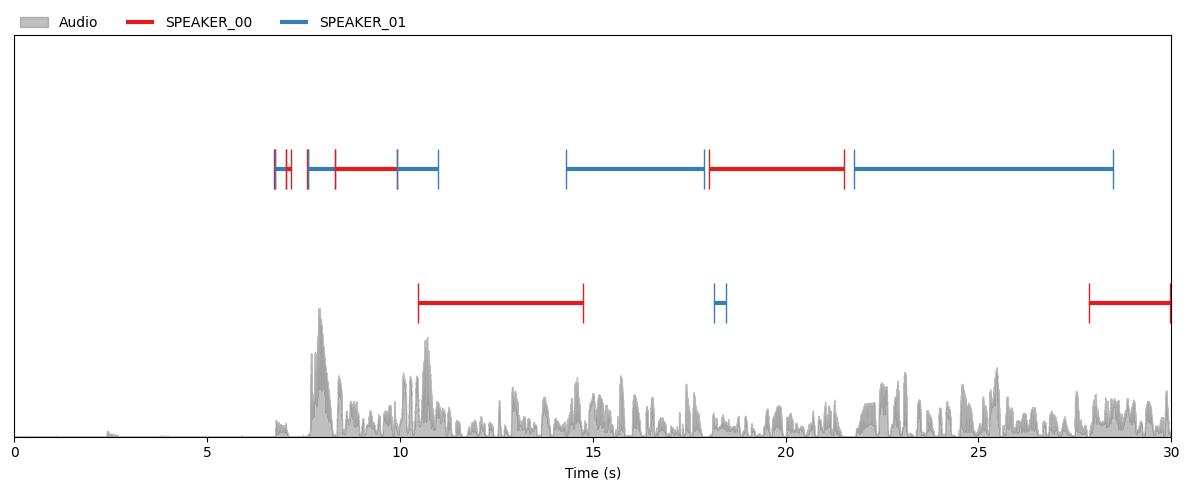

In [2]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pyannote.core import Segment, notebook

audio_path = 'cocktail_party_sample.wav'

annotation = diarization.speaker_diarization
y, sr = librosa.load(audio_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
notebook.crop = Segment(0, duration)

fig, ax = plt.subplots(figsize=(12, 5))

librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.5, color="gray", label="Audio")
notebook.plot_annotation(annotation, ax=ax, time=True, legend=True)

ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

Found 4!
Overlap detected from 10.5s to 11.0s
Overlap detected from 14.3s to 14.7s
Overlap detected from 18.2s to 18.4s
Overlap detected from 27.9s to 28.5s


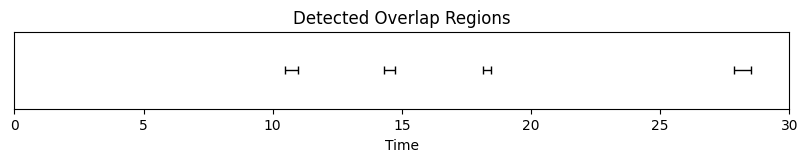

In [3]:
overlaps = annotation.get_overlap() # pyannote.core.annotation
print(f"Found {len(overlaps)}!")
for segment in overlaps:
    print(f"Overlap detected from {segment.start:.1f}s to {segment.end:.1f}s")

plt.figure(figsize=(10, 1))
notebook.plot_timeline(overlaps, time=True)
plt.title("Detected Overlap Regions")
plt.show()

In [ ]:
#
# Copyright 2018-2025 Picovoice Inc.
#
# You may not use this file except in compliance with the license. A copy of the license is located in the "LICENSE"
# file accompanying this source.
#
# Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on
# an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the
# specific language governing permissions and limitations under the License.
#

from confidential import PORCUPINE_ACCESS_KEY
import os
import struct
import wave
from datetime import datetime

import pvporcupine
from pvrecorder import PvRecorder


def main(): 
    access_key = PORCUPINE_ACCESS_KEY
    keywords = ['porcupine']
    keyword_paths = None
    device = 'cuda:0'
    sensitivities = None # = 0.8
    model_path = None
    library_path = None
    audio_device_index = -1
    output_path = None
    show_audio_devices = True

    if show_audio_devices:
        for i, device in enumerate(PvRecorder.get_available_devices()):
            print('Device %d: %s' % (i, device))
        

    if keyword_paths is None:
        if keywords is None:
            raise ValueError("Either `--keywords` or `--keyword_paths` must be set.")

        keyword_paths = [pvporcupine.KEYWORD_PATHS[x] for x in keywords]
    else:
        keyword_paths = keyword_paths

    if sensitivities is None:
        sensitivities = [0.5] * len(keyword_paths)

    if len(keyword_paths) != len(sensitivities):
        raise ValueError('Number of keywords does not match the number of sensitivities.')
    try:
        porcupine = pvporcupine.create(
            access_key=access_key,
            library_path=library_path,
            model_path=model_path,
            # device=device,
            keyword_paths=keyword_paths,
            sensitivities=sensitivities)
    except pvporcupine.PorcupineInvalidArgumentError as e:
        print("One or more arguments provided to Porcupine is invalid: ")
        print(e)
        raise e
    except pvporcupine.PorcupineActivationError as e:
        print("AccessKey activation error")
        raise e
    except pvporcupine.PorcupineActivationLimitError as e:
        print("AccessKey '%s' has reached it's temporary device limit" % access_key)
        raise e
    except pvporcupine.PorcupineActivationRefusedError as e:
        print("AccessKey '%s' refused" % access_key)
        raise e
    except pvporcupine.PorcupineActivationThrottledError as e:
        print("AccessKey '%s' has been throttled" % access_key)
        raise e
    except pvporcupine.PorcupineError as e:
        print("Failed to initialize Porcupine")
        raise e

    keywords = list()
    for x in keyword_paths:
        keyword_phrase_part = os.path.basename(x).replace('.ppn', '').split('_')
        if len(keyword_phrase_part) > 6:
            keywords.append(' '.join(keyword_phrase_part[0:-6]))
        else:
            keywords.append(keyword_phrase_part[0])

    print('Porcupine version: %s' % porcupine.version)

    recorder = PvRecorder(
        frame_length=porcupine.frame_length,
        device_index=audio_device_index)
    recorder.start()

    wav_file = None
    if output_path is not None:
        wav_file = wave.open(output_path, "w")
        wav_file.setnchannels(1)
        wav_file.setsampwidth(2)
        wav_file.setframerate(16000)

    print('Listening ... (press Ctrl+C to exit)')

    try:
        while True:
            pcm = recorder.read()
            result = porcupine.process(pcm)
            if wav_file is not None:
                wav_file.writeframes(struct.pack("h" * len(pcm), *pcm))

            if result >= 0:
                print('[%s] Detected %s' % (str(datetime.now()), keywords[result]))
    except KeyboardInterrupt:
        print('Stopping ...')
    finally:
        recorder.delete()
        porcupine.delete()
        if wav_file is not None:
            wav_file.close()


if __name__ == '__main__':
    main()

In [18]:
from confidential import PYANNOTEAI_API_KEY

access_key = PYANNOTEAI_API_KEY
sample_file = 'reference.wav'


# instantiate client
from pyannoteai.sdk import Client
client = Client(access_key)

# upload conversation file
media_url = client.upload(sample_file)

# submit a diarization job
job_id = client.voiceprint(media_url)

# retrieve diarization
diarization = client.retrieve(job_id)
voiceprint = diarization['output']['voiceprint'] #contains diarization output


In [6]:
import sounddevice as sd

for i, dev in enumerate(sd.query_devices()):
    print(i, dev['name'], "(Input channels:", dev['max_input_channels'], ")")


In [ ]:
# upload conversation file
sample_file = 'mixture_audio.wav'
media_url = client.upload(sample_file)
TARGET_NAME = "target_speaker"
data = {
    "url": media_url,
    "voiceprints": [
        {
            "label": TARGET_NAME, # The speaker label you want to assign
            "voiceprint": voiceprint  # Replace with actual voiceprint
        },
        # Add more voiceprints as needed
    ],
    # Optional matching parameters
    "matching": {
        "threshold": 50,  # Only match if confidence is 50% or higher
        "exclusive": True  # Prevent multiple speakers matching same voiceprint
    }
}

import requests
access_key = PYANNOTEAI_API_KEY
url = "https://api.pyannote.ai/v1/identify"

headers = {"Authorization": f"Bearer {access_key}", "Content-Type": "application/json"}

response = requests.post(url, headers=headers, json=data)

if response.status_code != 200:
    print(f"Error: {response.status_code} - {response.text}")
else:
    print(response.json())


if response.status_code != 200:
    print("\n❌ API ERROR!")
    print(f"Status Code: {response.status_code}")
    print(f"Server Message: {response.text}")


job_id = response.json()['jobId']
print(f"Job started: {job_id}")

# --- 6. WAIT FOR RESULT ---
while True:
    # Check the JOBS endpoint (Same fix as before)
    job_response = requests.get(
        f"https://api.pyannote.ai/v1/jobs/{job_id}",
        headers={"Authorization": f"Bearer {access_key}"}
    )
    
    job_data = job_response.json()
    
    if 'status' not in job_data:
        print("❌ Unexpected response:", job_data)
        break
        
    status = job_data['status']

    if status == "succeeded":
        print("\n🎉 ANALYSIS COMPLETE!")
        print("-" * 50)
        
        # The results are in output -> identification
        segments = job_data['output']['identification']
        
        found_target = False
        for segment in segments:
            speaker = segment['speaker']
            start = segment['start']
            end = segment['end']
            
            # If the AI recognized the voiceprint, 'speaker' will be TARGET_NAME
            # If not, it will be generic (SPEAKER_00, SPEAKER_01...)
            if speaker == TARGET_NAME:
                print(f"🟢 {speaker} found: {start:.1f}s -> {end:.1f}s")
                found_target = True
            else:
                print(f"⚪ Unknown ({speaker}): {start:.1f}s -> {end:.1f}s")
        
        if not found_target:
            print(f"⚠️ {TARGET_NAME} was not detected in this audio.")
            
        print("-" * 50)
        break
        
    elif status == "failed":
        print("\n❌ Job failed.")
        print(job_data)
        break
    
    print("Processing...", end="\r")


/home/tancrede/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannoteai/sdk/client.py:356: UserWarning: 
You are using pyannoteAI's temporary storage solution. Your file will be permanently deleted from our servers within 24hs. 
If you are running in production, we highly recommend to use your own storage to reduce network latency and obtain results faster. 
Please check our documentation at https://docs.pyannote.ai/ for more information.
  warnings.warn("""


{'jobId': '5d984478-cbc7-4071-9148-fd6be596d358', 'status': 'created'}


In [28]:

if response.status_code != 200:
    print("\n❌ API ERROR!")
    print(f"Status Code: {response.status_code}")
    print(f"Server Message: {response.text}")


job_id = response.json()['jobId']
print(f"Job started: {job_id}")

# --- 6. WAIT FOR RESULT ---
while True:
    # Check the JOBS endpoint (Same fix as before)
    job_response = requests.get(
        f"https://api.pyannote.ai/v1/jobs/{job_id}",
        headers={"Authorization": f"Bearer {access_key}"}
    )
    
    job_data = job_response.json()
    
    if 'status' not in job_data:
        print("❌ Unexpected response:", job_data)
        break
        
    status = job_data['status']

    if status == "succeeded":
        print("\n🎉 ANALYSIS COMPLETE!")
        print("-" * 50)
        
        # The results are in output -> identification
        segments = job_data['output']['identification']
        
        found_target = False
        for segment in segments:
            speaker = segment['speaker']
            start = segment['start']
            end = segment['end']
            
            # If the AI recognized the voiceprint, 'speaker' will be TARGET_NAME
            # If not, it will be generic (SPEAKER_00, SPEAKER_01...)
            if speaker == TARGET_NAME:
                print(f"🟢 {speaker} found: {start:.1f}s -> {end:.1f}s")
                found_target = True
            else:
                print(f"⚪ Unknown ({speaker}): {start:.1f}s -> {end:.1f}s")
        
        if not found_target:
            print(f"⚠️ {TARGET_NAME} was not detected in this audio.")
            
        print("-" * 50)
        break
        
    elif status == "failed":
        print("\n❌ Job failed.")
        print(job_data)
        break
    
    print("Processing...", end="\r")


Job started: 5d984478-cbc7-4071-9148-fd6be596d358
Processing...
🎉 ANALYSIS COMPLETE!
--------------------------------------------------
⚪ Unknown (SPEAKER_00): 1.3s -> 4.9s
🟢 target_speaker found: 5.3s -> 6.6s
🟢 target_speaker found: 6.7s -> 10.0s
⚪ Unknown (SPEAKER_00): 10.2s -> 13.7s
⚪ Unknown (SPEAKER_00): 13.9s -> 15.0s
--------------------------------------------------
